# Lab 4: Information theoretic key agreement
Laboratory session 4 of *Information Security*, AY 2024/25, team *pwnthemole3*.

In [19]:
import random
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Preparation: Channel and Encoder/Decoder Setup

In [20]:
# --- Hamming Code ---
# Hamming (7,4) codewords
Hamming_words = [
    '0000000', '1000110', '0100101', '0010011',
    '0001111', '1100011', '1010101', '1001001',
    '0110110', '0101010', '0011100', '1110000',
    '1101100', '1011010', '0111001', '1111111'
]

# Hamming distance between two binary strings
def hamming_distance(a, b):
    return sum(x != y for x, y in zip(a, b))


# Bitwise complement of a binary string
def bitwise_complement(word):
    return ''.join('1' if b == '0' else '0' for b in word)

# Generate all 3-bit messages
def generate_messages():
    return [format(i, '03b') for i in range(8)]

# Generate all 7-bit binary strings (used for Task 1)
def generate_all_7bit_words():
    return [format(i, '07b') for i in range(128)]

# --- Encoder --- for task 2
# Get bin: codeword with prefix 0+u and its complement
def get_bin(u):
    prefix = '0' + u
    for word in Hamming_words:
        if word.startswith(prefix):
            return [word, bitwise_complement(word)]
    return []

# Random binning encoder
def random_binning_encoder(u):
    return random.choice(get_bin(u))

# --- Channels ---
# Eavesdropper channel (flips up to 3 bits)
def eavesdropper_channel(x):
    x = list(x)
    for i in random.sample(range(7), random.randint(0, 3)):
        x[i] = '1' if x[i] == '0' else '0'
    return ''.join(x)

# Legitimate channel (flips 1 bit)
def legitimate_channel(x):
    x = list(x)
    i = random.randint(0, 6)
    x[i] = '1' if x[i] == '0' else '0'
    return ''.join(x)

# --- Decoder --- for task 3
# Decoder function
def decode(y):
    closest = min(Hamming_words, key=lambda w: hamming_distance(y, w))
    if closest[0] == '0':
        return closest[1:4]
    else:
        return bitwise_complement(closest[1:4])

# Task 1

Simulate Uniform Error Wiretap Channel

\Simulate Uniform Error Wiretap Channel
Estimated mutual information I(Y; Z | X = 1001000) = 0.003133 bits


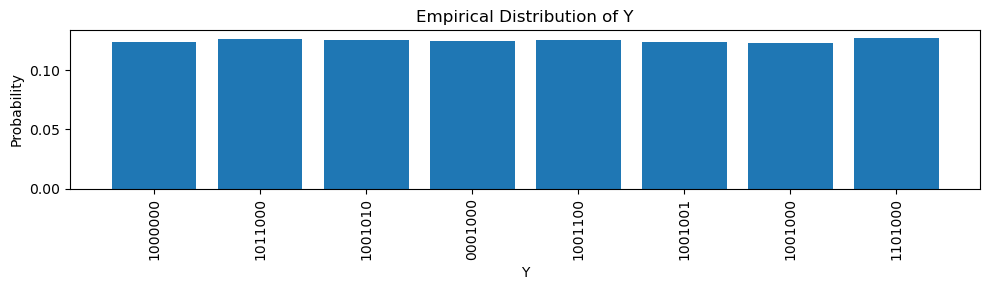

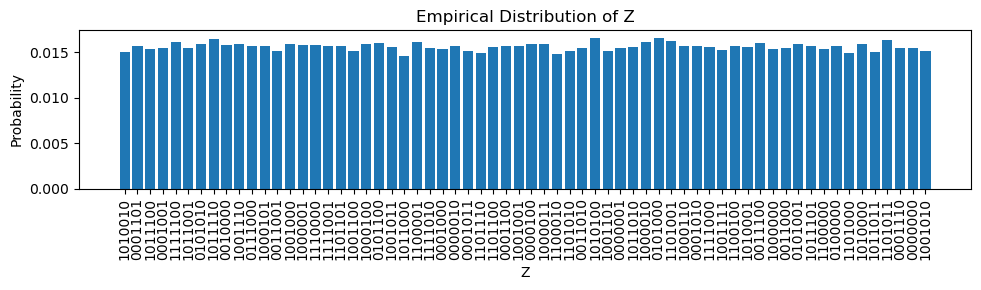

Std dev of P(Y|X): 0.001351
Std dev of P(Z|X): 0.000415
Y and Z appear conditionally independent given X.


In [21]:
def task1(x='1001000', trials=100000):
    print("\Simulate Uniform Error Wiretap Channel")
    y_samples = []
    z_samples = []

    # Generate sets of outputs within allowed Hamming distances
    def Ty_given_x(a):
        return [b for b in generate_all_7bit_words() if hamming_distance(a, b) <= 1]

    def Tz_given_x(a):
        return [c for c in generate_all_7bit_words() if hamming_distance(a, c) <= 3]

    Ty = Ty_given_x(x)
    Tz = Tz_given_x(x)

    # Sample from conditional distributions
    for _ in range(trials):
        y = random.choice(Ty)
        z = random.choice(Tz)
        y_samples.append(y)
        z_samples.append(z)

    # Empirical mutual information I(Y;Z|X)
    joint_counts = Counter(zip(y_samples, z_samples))
    y_counts = Counter(y_samples)
    z_counts = Counter(z_samples)

    mi = 0.0
    for (y, z), count in joint_counts.items():
        p_yz = count / trials
        p_y = y_counts[y] / trials
        p_z = z_counts[z] / trials
        mi += p_yz * np.log2(p_yz / (p_y * p_z))

    print(f"Estimated mutual information I(Y; Z | X = {x}) = {mi:.6f} bits")

    # Plot distribution
    def plot_bar(counter, label):
        probs = {k: v / trials for k, v in counter.items()}
        plt.figure(figsize=(10, 3))
        plt.bar(range(len(probs)), list(probs.values()))
        plt.title(f"Empirical Distribution of {label}")
        plt.xlabel(label)
        plt.ylabel("Probability")
        plt.xticks(range(len(probs)), list(probs.keys()), rotation=90)
        plt.tight_layout()
        plt.show()

    plot_bar(y_counts, "Y")
    plot_bar(z_counts, "Z")

    # Print std dev of output probabilities to check uniformity
    y_probs = np.array([v / trials for v in y_counts.values()])
    z_probs = np.array([v / trials for v in z_counts.values()])

    print(f"Std dev of P(Y|X): {np.std(y_probs):.6f}")
    print(f"Std dev of P(Z|X): {np.std(z_probs):.6f}")

    # Check how close mutual information is to 0
    if mi < 0.01:
        print("Y and Z appear conditionally independent given X.")
    else:
        print("Y and Z may not be conditionally independent.")


task1()

In [47]:
# Parity‐check matrix H for the (7,4) Hamming code
H = np.array([
    [1, 0, 0, 0, 1, 1, 1],
    [0, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 0, 1]
])

def compute_syndrome(word: np.ndarray) -> np.ndarray:
    """
    Compute the 3‐bit syndrome H⋅word over GF(2).
    """
    return (H @ word) % 2

def correct_forward(received: np.ndarray, syndrome_alice: np.ndarray) -> np.ndarray:
    """
    Given a 7‐bit 'received' word and Alice's syndrome, recover the original codeword
    by locating the single‐bit error via the syndrome difference.
    """
    # Bob/Eve compute their own syndrome
    syn_recv = compute_syndrome(received)
    # The difference (in GF(2)) is the syndrome of the error vector
    err_synd = (syn_recv ^ syndrome_alice) % 2

    # If zero, no error
    if np.all(err_synd == 0):
        return received.copy()

    # Otherwise find which column of H matches that syndrome
    for j in range(H.shape[1]):
        if np.array_equal(H[:, j], err_synd):
            corrected = received.copy()
            corrected[j] ^= 1
            return corrected

    # Should never happen if at most one error
    raise ValueError("Unrecoverable error pattern")


# Task 2

Forward Reconciliation

In [48]:
# 1) Pick an arbitrary 7-bit codeword x
x = np.array([1, 0, 0, 1, 0, 0, 0])

# 2) Simulate Bob’s and Eve’s channels: at most one bit flip
def flip_one(bitstring, pos):
    out = bitstring.copy()
    out[pos] ^= 1
    return out

# Test *all* single‐bit errors (and the no-error case)
print(" error_pos | Bob recovers | Eve recovers")
print("---------------------------------------")
for err_b in range(-1, 7):   # -1 means no error
    y = x.copy() if err_b<0 else flip_one(x, err_b)
    for err_e in [err_b]:    # you can also test different error for Eve
        z = x.copy() if err_e<0 else flip_one(x, err_e)

        # Alice’s syndrome
        c = compute_syndrome(x)

        x_hat_bob = correct_forward(y, c)
        x_hat_eve = correct_forward(z, c)

        print(f"    {err_b:2d}     |     {x_hat_bob.tolist()==x.tolist()}     |     {x_hat_eve.tolist()==x.tolist()}")

 error_pos | Bob recovers | Eve recovers
---------------------------------------
    -1     |     True     |     True
     0     |     True     |     True
     1     |     True     |     True
     2     |     True     |     True
     3     |     True     |     True
     4     |     True     |     True
     5     |     True     |     True
     6     |     True     |     True


# Task 3

Reverse Reconciliation

In [49]:
# 1) Original x
x = np.array([1, 0, 0, 1, 0, 0, 0])

# 2) Simulate one‐bit errors on A→B and A→E independently
def flip_one(word, pos):
    w = word.copy()
    w[pos] ^= 1
    return w

print(" err_b | err_e | Alice recovers y | Eve recovers y?")
print("---------------------------------------------------")
for err_b in range(-1, 7):      # -1 means no error on Bob’s branch
    y = x if err_b < 0 else flip_one(x, err_b)
    sB = compute_syndrome(y)    # Bob’s syndrome

    # Alice’s reconstruction of y
    y_hat_A = correct_forward(x, sB)

    for err_e in range(-1, 7):  # -1 means no error on Eve’s branch
        z = x if err_e < 0 else flip_one(x, err_e)
        # Eve tries the *same* correction
        y_hat_E = correct_forward(z, sB)

        okA = np.array_equal(y_hat_A, y)
        okE = np.array_equal(y_hat_E, y)
        print(f"  {err_b:2d}   |  {err_e:2d}   |      {okA}       |     {okE}")

 err_b | err_e | Alice recovers y | Eve recovers y?
---------------------------------------------------
  -1   |  -1   |      True       |     True
  -1   |   0   |      True       |     True
  -1   |   1   |      True       |     True
  -1   |   2   |      True       |     True
  -1   |   3   |      True       |     True
  -1   |   4   |      True       |     True
  -1   |   5   |      True       |     True
  -1   |   6   |      True       |     True
   0   |  -1   |      True       |     True
   0   |   0   |      True       |     True
   0   |   1   |      True       |     False
   0   |   2   |      True       |     False
   0   |   3   |      True       |     False
   0   |   4   |      True       |     False
   0   |   5   |      True       |     False
   0   |   6   |      True       |     False
   1   |  -1   |      True       |     True
   1   |   0   |      True       |     False
   1   |   1   |      True       |     True
   1   |   2   |      True       |     False
   1   |